# Segmentation

## Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/MyDrive/Dataset/Finger vein /ML Train Data/full_data_bmp.zip"

# Converting Bitmap image to *JPEG*

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
from PIL import Image

In [ ]:
!mkdir "/content/JPEG_Data"
directory = '/content/full_data_bmp'
output = '/content/JPEG_Data'

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".bmp") or filename.endswith(".png"):
        image = cv2.imread(os.path.join(directory, filename))
        cv2.imwrite(os.path.join(output , filename.replace('.bmp', '.jpg')), image)
        #cv2_imshow(image)

    else:
        continue

# Resizing Images

In [ ]:
!mkdir "/content/Resized_Grey"
directory = '/content/JPEG_Data'
output = "/content/Resized_Grey"

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(directory, filename), 0)
        resize = cv2.resize(img, (256, 256))
        cv2.imwrite(os.path.join(output , filename), resize)
        #print(filename)
        #cv2_imshow(resize)
    else:
        continue

# semantic segmentation using U-Net


In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob

In [ ]:
image_directory = '/content/drive/MyDrive/Datasets/FV/Segmentation Mix'
mask_directory = '/content/drive/MyDrive/Datasets/FV/Segmentation Mask'

In [ ]:
SIZE = 256
num_images = 2000

Load images and masks in order so they match

In [ ]:
image_names = glob.glob("/content/Resized_Grey/*.jpg")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 0) for image in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
np.shape(image_dataset)

(2000, 256, 256, 1)

In [ ]:
!mkdir "/content/mask_resized"

In [ ]:
from google.colab.patches import cv2_imshow


In [ ]:
!mkdir "/content/output"
!mkdir "/content/mask"

In [ ]:
directory = '/content/Resized_Grey'
#output = "/content/output"
mask = "/content/mask_resized"
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        print(os.path.join(mask , '_mask_'+filename))
        img = cv2.imread(os.path.join(directory, filename), 0)
        ret, bw_img = cv2.threshold(img, 70, 255, cv2.THRESH_BINARY)
        bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        cv2.imwrite(os.path.join(mask ,filename), bw_img)
        #cv2_imshow(bw_img)
    else:
        continue




Read masks the same way.

In [ ]:
mask_names = glob.glob("/content/mask_resized/*.jpg")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (2000, 256, 256, 1)
Mask data shape is:  (2000, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0   1   2   3   4   5   6   7   8   9  10  11 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255]


In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_test, y_train = train_test_split(image_dataset, mask_dataset,test_size=1/3, random_state=0)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


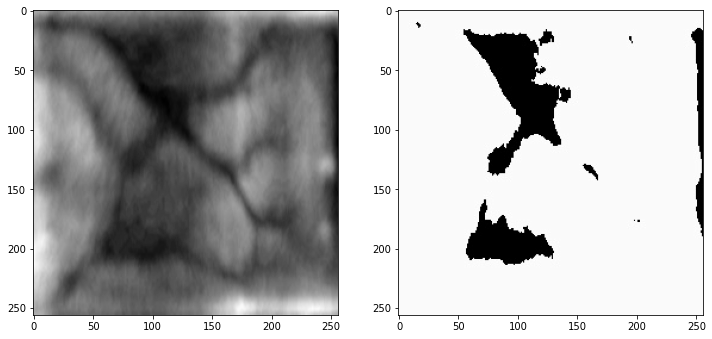

In [ ]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#ModelCheckpoint callback saves a model at some interval.
filepath="/content/drive/MyDrive/Dataset/Finger vein /ML Train Data/all new/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)


log_csv = CSVLogger('/content/drive/MyDrive/Dataset/Finger vein /ML Train Data/all new/my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    shuffle=False)


In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/fv_u-net_10epochs.hdf5')

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Dataset/Finger vein /ML Train Data/all new/weights-improvement-211-0.92.h5", compile=False)


In [ ]:
#IOU
y_pred=model.predict(X_test)


13/13 [==============================] - 620s 48s/step


In [ ]:
from tensorflow.keras.metrics import MeanIoU

In [ ]:
y_pred_thresholded = y_pred > 0.9
n_classes = 10
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.22841127


In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential, Model


Read image and corresponding mask

In [ ]:
SIZE=512

Read the image

In [ ]:
img=cv2.imread('/content/JPEG_Data/001_01.jpg', 0)   #Change 1 to 0 for grey images
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Changing BGR to RGB to show images in true colors
img=cv2.resize(img,(SIZE, SIZE))
print(img.shape)

(512, 512)


In [ ]:
#Get image shape ready for the network
img_array = np.expand_dims(img, axis=2)
print(img_array.shape)

(512, 512, 1)


Read the mask

In [ ]:
mask=cv2.imread('/content/mask/001_01.jpg', 0)   #Change 1 to 0 for grey images

mask=cv2.resize(mask,(SIZE, SIZE))
print(mask.shape)


(512, 512)


In [ ]:
mask_array = np.expand_dims(mask, axis=2) #Grayscale image, so let us expand dim to indicate we have 1 channel
#mask_array = np.expand_dims(mask, axis=0) #Expand dim along axis 0 to get it to the right shape for the network
print(mask_array.shape)

(512, 512, 1)


In [ ]:
img_array = img_array.astype('float32') / 255.  #Scale image pixel values to between 0 and 1
mask_array = mask_array.astype('float32') / 255.  #Mask has values 0, 255 - scale them to 0 and 1.


In [ ]:
plt.subplot(1,2,1)
plt.imshow(img_array[0,:,:,0], cmap='gray')
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(mask_array[0,:,:])
plt.title('Mask')
plt.show()

In [ ]:
SIZE = 512

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))


model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  #Using binary cross entropy loss. Try other losses.
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 512, 512, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 256, 256, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 256)     295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 256)     

In [ ]:
history = model.fit(X_train, y_train,
                    #batch_size = 8,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    #callbacks=callbacks_list
                    )

In [ ]:
model.fit(img_array, mask_array, epochs=500) #If the model does not converge try a few times....


Epoch 1/500


16/16 [==============================] - 9s 18ms/step - loss: 0.4749 - accuracy: 0.7749
Epoch 2/500
16/16 [==============================] - 0s 18ms/step - loss: 0.2739 - accuracy: 0.7858
Epoch 3/500
16/16 [==============================] - 0s 18ms/step - loss: 0.1438 - accuracy: 0.8302
Epoch 4/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0959 - accuracy: 0.8956
Epoch 5/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0461 - accuracy: 0.8962
Epoch 6/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0338 - accuracy: 0.8993
Epoch 7/500
16/16 [==============================] - 0s 17ms/step - loss: 0.0283 - accuracy: 0.9005
Epoch 8/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0275 - accuracy: 0.9005
Epoch 9/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0253 - accuracy: 0.9009
Epoch 10/500
16/16 [==============================] - 0s 18ms/step - loss: 0.0242 - accuracy: 0.9012
Epoch 11/50

In [ ]:
pred = model.predict(img_array)



16/16 [==============================] - 0s 9ms/step


In [ ]:
#IOU
y_pred=model.predict(img_array)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(mask_array, y_pred_thresholded)
union = np.logical_or(mask_array, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

16/16 [==============================] - 0s 9ms/step


ValueError: ignored

TypeError: ignored

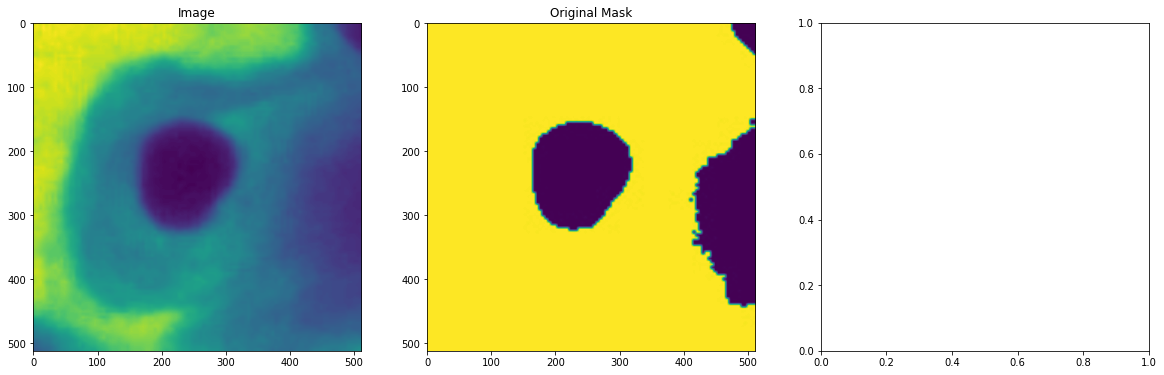

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask)
plt.title('Original Mask')
plt.subplot(1,3,3)
plt.imshow(pred[0,:,:,:])
plt.title('Predicted Mask')
plt.show()